In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
RANDOM_STATE = 42
df = pd.read_excel('ap_pro_data.xls', 'Physicians - Discretized', skiprows=2)
df.head()

,VisitID,RecordID,Age,Sex,PainDur,PainSite,PainType,Vomiting,PrevVis,Temp,TendSite,Guard,RebTend,PainShift,WBC,Triage,Observer
0,1,1,ge5y,female,gt24h_le7d,lower_abdomen,constant,yes,no,ge37_le39,lower_abdomen,no,no,no,?,discharge,discharge
1,2,2,lt5y,female,gt24h_le7d,lower_abdomen,intermittent,no,no,lt37,other,no,no,no,?,discharge,discharge
2,3,3,ge5y,male,le24h,lower_abdomen,constant,no,no,lt37,lower_abdomen,no,yes,no,ge12,consult,observation
3,4,4,ge5y,female,le24h,other,constant,no,yes,ge37_le39,other,no,no,no,ge12,discharge,discharge
4,5,5,lt5y,female,le24h,other,intermittent,yes,no,ge37_le39,other,no,no,no,?,discharge,observation


In [3]:
df.describe(include='all')

,VisitID,RecordID,Age,Sex,PainDur,PainSite,PainType,Vomiting,PrevVis,Temp,TendSite,Guard,RebTend,PainShift,WBC,Triage,Observer
count,457.000000,457.000000,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457
unique,NaN,NaN,2,2,4,3,3,3,3,4,4,3,3,3,4,3,3
top,NaN,NaN,ge5y,female,le24h,other,intermittent,no,no,lt37,other,no,no,no,?,discharge,discharge
freq,NaN,NaN,369,237,275,276,281,265,437,276,230,385,404,371,354,348,265
mean,229.000000,229.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,132.068795,132.068795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,115.000000,115.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,229.000000,229.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,343.000000,343.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['WBC'].value_counts()

WBC
?           354
gt4_lt12     58
ge12         42
le4           3
Name: count, dtype: int64

## Binaryzacja klas

Klasy 'discharge' oraz 'observation' zostały zmapowane na klasę negatywną, natomiast klasa 'consult' została zmapowana na klasę pozytywną

In [5]:
df = df.drop(['VisitID', 'RecordID', 'Observer', 'WBC'], axis=1)
mapper = {'discharge': 0, 'observation': 0, 'consult': 1}
df['Triage'] = df['Triage'].map(mapper)
df = pd.get_dummies(df)
df.head()

,Triage,Age_ge5y,Age_lt5y,Sex_female,Sex_male,PainDur_?,PainDur_gt24h_le7d,PainDur_gt7d,PainDur_le24h,PainSite_RLQ,...,TendSite_other,Guard_?,Guard_no,Guard_yes,RebTend_?,RebTend_no,RebTend_yes,PainShift_?,PainShift_no,PainShift_yes
0,0,True,False,True,False,False,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False
1,0,False,True,True,False,False,True,False,False,False,...,True,False,True,False,False,True,False,False,True,False
2,1,True,False,False,True,False,False,False,True,False,...,False,False,True,False,False,False,True,False,True,False
3,0,True,False,True,False,False,False,False,True,False,...,True,False,True,False,False,True,False,False,True,False
4,0,False,True,True,False,False,False,False,True,False,...,True,False,True,False,False,True,False,False,True,False


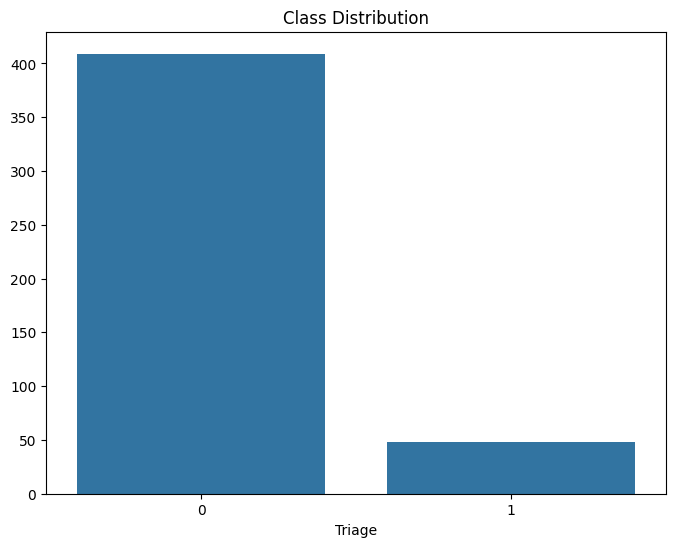

In [6]:
# Class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=df['Triage'].value_counts().index, y=df['Triage'].value_counts().values)
plt.title('Class Distribution')
plt.show()

## Klasyfikator bazowy

Jako klasyfikator bazowy przyjąłem model naiwnego bayessa

In [7]:
baseline_clf = GaussianNB()
baseline_clf.fit(df.drop('Triage', axis=1), df['Triage'])

GaussianNB()

## Klasyfikatory docelowe
Jako klasyfikatory docelowe, przyjąłem las losowy oraz XGBoost. Obydwa klasyfikatory zostały poprzedzone StandardScalerem, który ma za zadanie przeskalować dane wejściowe, a także algorytmem SMOTE, który dogenerowuje syntetyczne przykłady z klasy mniejszościowej

In [8]:
X = df.drop('Triage', axis=1).values
y = df['Triage'].values

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Random forest pipeline with SMOTE
target_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

target_param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 6, 9],
    'clf__min_samples_split': [2, 4],
    'clf__min_samples_leaf': [1, 2]
}

target_clf = GridSearchCV(
    target_pipeline,
    target_param_grid,
    cv=3,
    scoring='average_precision',
    n_jobs=-1
)

# XGBoost pipeline with SMOTE
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
])

xgb_param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 6, 9],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__scale_pos_weight': [1, 5]
}

xgb_clf = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    scoring='average_precision',
    n_jobs=-1
)

results = {
    'baseline': {
        'auroc': [], 'auprc': [],
        'med_fnr': [], 'med_fpr': [], 'med_pct': [],
        'high_fnr': [], 'high_fpr': [], 'high_pct': [],
    },
    'target': {
        'auroc': [], 'auprc': [],
        'med_fnr': [], 'med_fpr': [], 'med_pct': [],
        'high_fnr': [], 'high_fpr': [], 'high_pct': [],
    },
    'xgboost': {
        'auroc': [], 'auprc': [],
        'med_fnr': [], 'med_fpr': [], 'med_pct': [],
        'high_fnr': [], 'high_fpr': [], 'high_pct': [],
    }
}

## Walidacja krzyżowa

In [9]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)

fold_count = 0
for train_idx, test_idx in cv.split(X, y):
    fold_count += 1
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train all classifiers
    baseline_clf.fit(X_train, y_train)
    target_clf.fit(X_train, y_train)
    xgb_clf.fit(X_train, y_train)
    

    for clf_name, clf in [('baseline', baseline_clf), ('target', target_clf), ('xgboost', xgb_clf)]:
        y_proba = clf.predict_proba(X_test)[:, 1]
        
        # Calculate AUROC and AUPRC
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
        
        auroc = auc(fpr, tpr)
        auprc = auc(recall, precision)
        
        results[clf_name]['auroc'].append(auroc)
        results[clf_name]['auprc'].append(auprc)
        
        train_proba = clf.predict_proba(X_train)[:, 1]
        train_precision, train_recall, train_pr_thresholds = precision_recall_curve(y_train, train_proba)
        train_fpr, train_tpr, train_roc_thresholds = roc_curve(y_train, train_proba)
        
        # Medium-risk threshold -> sensitivity >= 99%
        # Sensitivity = Recall = TPR
        sensitivity_99_idx = np.where(train_tpr >= 0.99)[0][0]  # First index where sensitivity >= 99%
        medium_risk_threshold = train_roc_thresholds[sensitivity_99_idx]
        
        # High-risk threshold: specificity >= 90%
        # Specificity = 1 - FPR
        specificity_90_idx = np.where(1 - train_fpr >= 0.90)[0][-1]  # Last index where specificity >= 90%
        high_risk_threshold = train_roc_thresholds[specificity_90_idx]
        
        y_pred_medium = np.where(y_proba < medium_risk_threshold, 0, -1)  # Negative or unclassified
        y_pred_high = np.where(y_proba >= high_risk_threshold, 1, -1)     # Positive or unclassified
        
        # Combine predictions
        y_pred_combined = np.copy(y_pred_medium)
        high_mask = y_pred_high == 1
        y_pred_combined[high_mask] = 1
        
        # Calculate metrics
        medium_mask = y_pred_medium != -1
        if medium_mask.sum() > 0:
            # FNR
            fn_medium = np.sum((y_pred_medium == 0) & (y_test == 1))
            actual_pos_medium = np.sum(y_test[medium_mask] == 1)
            med_fnr = fn_medium / actual_pos_medium if actual_pos_medium > 0 else 0
            
            # FPR
            fp_medium = np.sum((y_pred_medium == 1) & (y_test == 0))
            actual_neg_medium = np.sum(y_test[medium_mask] == 0)
            med_fpr = fp_medium / actual_neg_medium if actual_neg_medium > 0 else 0
            
            # Percentage classified as negative
            med_pct = np.mean(y_pred_medium == 0)
        else:
            med_fnr, med_fpr, med_pct = 0, 0, 0
            
        high_mask = y_pred_high != -1
        if high_mask.sum() > 0:
            # FNR
            fn_high = np.sum((y_pred_high == 0) & (y_test == 1))
            actual_pos_high = np.sum(y_test[high_mask] == 1)
            high_fnr = fn_high / actual_pos_high if actual_pos_high > 0 else 0
            
            # FPR
            fp_high = np.sum((y_pred_high == 1) & (y_test == 0))
            actual_neg_high = np.sum(y_test[high_mask] == 0)
            high_fpr = fp_high / actual_neg_high if actual_neg_high > 0 else 0
            
            # Percentage classified as positive
            high_pct = np.mean(y_pred_high == 1)
        else:
            high_fnr, high_fpr, high_pct = 0, 0, 0
        
        results[clf_name]['med_fnr'].append(med_fnr)
        results[clf_name]['med_fpr'].append(med_fpr)
        results[clf_name]['med_pct'].append(med_pct)
        results[clf_name]['high_fnr'].append(high_fnr)
        results[clf_name]['high_fpr'].append(high_fpr)
        results[clf_name]['high_pct'].append(high_pct)

## Wyniki

In [10]:
print("\n===== RESULTS =====")
for clf_name in ['baseline', 'target', 'xgboost']:
    print(f"\n{clf_name.upper()} CLASSIFIER:")
    print(f"AUPRC: {np.mean(results[clf_name]['auprc']):.4f} (±{np.std(results[clf_name]['auprc']):.4f})")
    print(f"AUROC: {np.mean(results[clf_name]['auroc']):.4f} (±{np.std(results[clf_name]['auroc']):.4f})")
    
    print("\nMedium-risk threshold (neg < threshold):")
    print(f"FNR: {np.mean(results[clf_name]['med_fnr']):.4f} (±{np.std(results[clf_name]['med_fnr']):.4f})")
    print(f"FPR: {np.mean(results[clf_name]['med_fpr']):.4f} (±{np.std(results[clf_name]['med_fpr']):.4f})")
    print(f"% classified as negative: {np.mean(results[clf_name]['med_pct'])*100:.2f}%")
    
    print("\nHigh-risk threshold (pos >= threshold):")
    print(f"FNR: {np.mean(results[clf_name]['high_fnr']):.4f} (±{np.std(results[clf_name]['high_fnr']):.4f})")
    print(f"FPR: {np.mean(results[clf_name]['high_fpr']):.4f} (±{np.std(results[clf_name]['high_fpr']):.4f})")
    print(f"% classified as positive: {np.mean(results[clf_name]['high_pct'])*100:.2f}%")
    
    # Calculate gray zone percentage
    gray_zone_pct = 100 - (np.mean(results[clf_name]['med_pct'])*100 + np.mean(results[clf_name]['high_pct'])*100)
    print(f"Gray zone (moderate risk): {gray_zone_pct:.2f}%")


===== RESULTS =====

BASELINE CLASSIFIER:
AUPRC: 0.5606 (±0.0955)
AUROC: 0.7548 (±0.1554)

Medium-risk threshold (neg < threshold):
FNR: 0.5600 (±0.4964)
FPR: 0.0000 (±0.0000)
% classified as negative: 23.98%

High-risk threshold (pos >= threshold):
FNR: 0.0000 (±0.0000)
FPR: 0.0800 (±0.2713)
% classified as positive: 1.40%
Gray zone (moderate risk): 74.62%

TARGET CLASSIFIER:
AUPRC: 0.6012 (±0.1439)
AUROC: 0.9069 (±0.0654)

Medium-risk threshold (neg < threshold):
FNR: 0.2800 (±0.4490)
FPR: 0.0000 (±0.0000)
% classified as negative: 31.01%

High-risk threshold (pos >= threshold):
FNR: 0.0000 (±0.0000)
FPR: 1.0000 (±0.0000)
% classified as positive: 17.20%
Gray zone (moderate risk): 51.79%

XGBOOST CLASSIFIER:
AUPRC: 0.5881 (±0.1794)
AUROC: 0.8969 (±0.0694)

Medium-risk threshold (neg < threshold):
FNR: 0.3600 (±0.4800)
FPR: 0.0000 (±0.0000)
% classified as negative: 48.84%

High-risk threshold (pos >= threshold):
FNR: 0.0000 (±0.0000)
FPR: 1.0000 (±0.0000)
% classified as positive: 1

## Wnioski

### Naive Bayes
- **AUPRC**: 0.5606 ±0.0955 | **AUROC**: 0.7548 ±0.1554  
- Model bazowy cechuje się najsłabszą skutecznością predykcji spośród trzech modeli.
- **FNR = 0.5600** dla progu medium-risk wskazuje na wysoką liczbę przypadków fałszywie negatywnych.
- Tylko **1.40%** przypadków zostało zakwalifikowanych jako wysokiego ryzyka.
- Duża **szara strefa**: 74.62%, oznacza że większość przypadków nie została jednoznacznie sklasyfikowana.

---

### Random Forest
- **AUPRC**: 0.6012 ±0.1439 | **AUROC**: 0.9069 ±0.0654  
- Najlepszy model pod względem AUROC, z dobrze zbalansowaną jakością predykcji.
- **FNR = 0.2800** przy medium-risk, co jest znaczącą poprawą w porównaniu do modelu bazowego.
- **31.01%** przypadków sklasyfikowano jako negatywne, **17.20%** jako pozytywne.
- Szara strefa zmniejszona do **51.79%**, co oznacza większą decyzyjność modelu.

---

### XGBoost
- **AUPRC**: 0.5881 ±0.1794 | **AUROC**: 0.8969 ±0.0694  
- Wyniki nieco gorsze od Random Forest, ale lepsze niż baseline.
- **FNR = 0.3600** przy medium-risk — więcej błędów fałszywie negatywnych niż Target.
- Model klasyfikuje najwięcej przypadków jednoznacznie: **48.84%** jako negatywne, **18.59%** jako pozytywne.
- **Najmniejsza szara strefa**: 32.57% — model podejmuje najwięcej jednoznacznych decyzji.

---


- **Random Forest** oferuje najlepszą jakość klasyfikacji, zachowując przy tym umiarkowaną liczbę przypadków nierozstrzygniętych.
- **XGBoost** wyróżnia się największą decyzyjnością, ale kosztem nieco wyższej liczby błędów.
- **Naive Bayes** służy jako punkt odniesienia — jego skuteczność jest najniższa, a szara strefa największa.
